In [ ]:
#libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


#clustering
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

#ML
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix, recall_score
from sklearn import metrics
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE

#xgb
import xgboost as xgb

#utils for visualisation
import scienceplots


plt.style.use(["science", "no-latex"])
plt.rcParams["font.family"] = "Times New Roman"

# Ecotox dataset

In [ ]:
ecotox = pd.read_excel(os.path.join('data', 'envirotox_20240201154635.xlsx'))
ecotox = ecotox[(ecotox['Test statistic'] == 'EC50') & (ecotox['Duration (days)'] == 4)]
plt.style.use(["science", "no-latex"])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


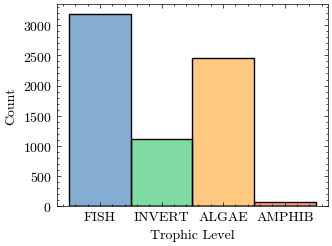

In [ ]:
plt.figure()
sns.histplot(data=ecotox, x='Trophic Level', hue='Trophic Level')
plt.legend()
plt.savefig('./plots/barplot_trophic.png', dpi=300)

# Flags dataset

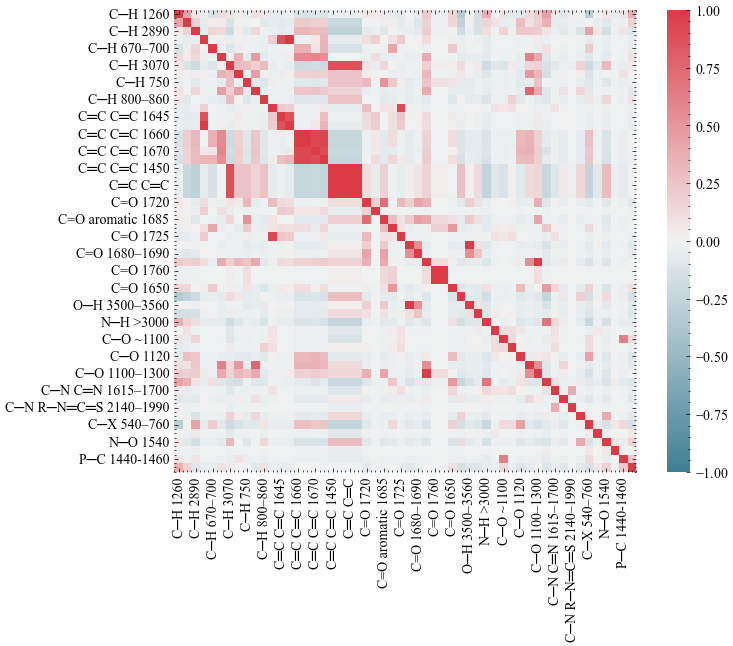

In [ ]:
flags = pd.read_csv(os.path.join('data', 'EC50_flags_short_names.csv'))
flags = flags.drop(columns='Unnamed: 0')
# column_list = [i for i in flags.columns if '─' in i]
X = flags.iloc[:, 25:]


cols_same_values = []
for col in X.columns:
    if X[col].nunique()==1:
        cols_same_values.append(col)
        
X = X.drop(columns=cols_same_values)
y = flags['Effect value']

corr = X.corr()


# Select upper triangle of correlation matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]

column_list = [i for i in X.columns if '─' in i]
drop_list = []
for i in column_list:
    if X[i].sum() == 0:
        drop_list.append(i)

X.drop(drop_list, axis=1, inplace=True)
# corr = corr.T.reset_index(drop=True).T.reset_index(drop=True)
corr = X.corr()
# corr = corr.dropna(axis=0)
f, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)

# plt.savefig('./plots/corr-plot.png', dpi=300)

# Datasets

In [ ]:
def get_data():
    flags = pd.read_csv(os.path.join('data', 'EC50_flags_short_names.csv'))
    flags = flags.drop(columns='Unnamed: 0')

    mask = flags['Trophic Level']=='ALGAE'
    flags = flags.loc[mask]
    tox_list = []
    for i,row in flags.iterrows():
        if row['Effect value'] >= 100:
            tox_list.append(0)
        else:
            tox_list.append(1) 
    flags.insert(0, 'tox_flag', tox_list)
    flags = flags.drop_duplicates(subset='smiles')
    
    X = flags.iloc[:, 26:]
    
    cols_same_values = []
    for col in X.columns:
        if X[col].nunique()==1:
            cols_same_values.append(col)
            
    X = X.drop(columns=cols_same_values)
    y = flags['tox_flag']
    corr = X.corr()
    
    
    # Select upper triangle of correlation matrix
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    
    # Find features with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
    
    column_list = [i for i in X.columns if '─' in i]
    drop_list = []
    for i in column_list:
        if X[i].sum() == 0:
            drop_list.append(i)
    X = X.drop(drop_list, axis=1)
    X = X.drop(to_drop, axis=1)
    return X, y


X, y = get_data()

# Models

## Cross-validation and parameter optimization

In [ ]:

def init_models():
    return { 
        "kNN": KNeighborsClassifier(n_jobs=6), 
        "SVC": SVC(), # to speed up LinearSVC
        "RandomForest": RandomForestClassifier(bootstrap=True, n_jobs=6), 
        "XGB": xgb.XGBClassifier(n_jobs=6), 
        "LogisticRegression": LogisticRegression()}

def get_random_forest():
    n_estimators = np.arange(100,200,20)
    max_depth = np.arange(10,110,11)
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    random_grid = {'n_estimators': n_estimators,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf}
    return {"grid":random_grid}

def get_svm():
    svc_grid = {'C': [0.01, 0.1, 10,100], 
              'gamma': [1, 0.1, 0.01],
              'kernel': ['rbf', 'linear', 'poly']
             }
    return {"grid":svc_grid}
def get_KNN():
    metric = ['euclidean','manhattan','chebyshev','minkowski']
    n_neighbors = np.arange(4,15,2)
    weights = ['uniform','distance']
    random_grid_knn = {'n_neighbors': n_neighbors,
        'weights': weights,
        'metric': metric}
    return {"grid":random_grid_knn}

def get_XGB():
    params = { 'max_depth': [3,6,10],
           "min_child_weight": [0.5, 1, 2],
           'n_estimators': np.arange(10,80,20),
           'colsample_bytree': [0.3, 0.7, 1]}
    return {"grid":params}


def get_LogReg():
    params = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}
    return {"grid":params}



In [ ]:
models = {
    'RandomForest': get_random_forest(), 
     "SVC":get_svm(),
    "kNN":get_KNN(),
    "XGB":get_XGB()}

In [ ]:
X, y = get_data()

In [ ]:
X, y = get_data()
print('df
shape before SMOTE', X.shape)
smote = SMOTE()
X, y = smote.fit_resample(X,y) #drops 3 columns: key, class, and forest
print('df shape after SMOTE', X.shape)

df shape before SMOTE (252, 37)
df shape after SMOTE (436, 37)


In [ ]:
# Загрузка набора данных

# Разделение набора данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Нормализация признаков
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Создание модели kNN
knn = KNeighborsClassifier(n_neighbors=5)

# Обучение модели
knn.fit(X_train, y_train)

# Предсказание на тестовой выборке
predictions = knn.predict(X_test)

# Вычисление матрицы ошибок, F1-score и accuracy
conf_matrix = confusion_matrix(y_test, predictions)
f1 = f1_score(y_test, predictions, average='weighted')
accuracy = accuracy_score(y_test, predictions)

print(f"Confusion Matrix:\nTrue positive: {conf_matrix[1,1]}\nTrue Negative: {conf_matrix[0,0]}\nFalse Negative: {conf_matrix[1,0]}\nFalse Negative: {conf_matrix[0,1]}")
print("F1 Score: ", f1)
print("Accuracy: ", accuracy)


Confusion Matrix:
True positive: 34
True Negative: 52
False Negative: 18
False Negative: 5
F1 Score:  0.7847184239584731
Accuracy:  0.7889908256880734


In [ ]:

best_models = {}

container = []

df_cont = {}
best_models ={}
for i in range(15): 
    print(i)
    for model_name, param_grid in models.items():
        model = init_models()[model_name]
        gs = RandomizedSearchCV(estimator=model,
                        param_distributions = param_grid['grid'],
                        n_iter = 10,
                        cv = 5,
                        scoring= 'f1', 
                        verbose=0,
                       n_jobs = 10)
    
    
        gs.fit(X_train, y_train)
        y_pred = gs.best_estimator_.predict(X_test)
        model_fit = gs.best_estimator_
        best_models[model_name] =  model_fit
        f1 = f1_score(y_test, y_pred)
        recall = metrics.recall_score(y_test, y_pred)
        # print(f'{model_name}, f1 - {f1:.2f}, recall - {recall:.2f}')
        container.append({'iter':i, 'model': model_name, 'f1_score': f1, 'recall': recall})
    # break
# df_metrics = pd.DataFrame(container)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [ ]:
df_metrics.to_csv('./data/metrics.csv', index=False)

In [ ]:
df_metrics = pd.DataFrame(container)

In [ ]:
df_metrics.groupby(['model']).mean()

,iter,f1_score,recall
model,,,
RandomForest,7.0,0.898427,0.919231
SVC,7.0,0.885743,0.856410
XGB,7.0,0.900907,0.950000
kNN,7.0,0.836555,0.792308


In [ ]:
df_metrics.groupby(['model']).std()

,iter,f1_score,recall
model,,,
RandomForest,4.472136,0.023984,0.029255
SVC,4.472136,0.036038,0.049226
XGB,4.472136,0.007607,0.014169
kNN,4.472136,0.010281,0.022047


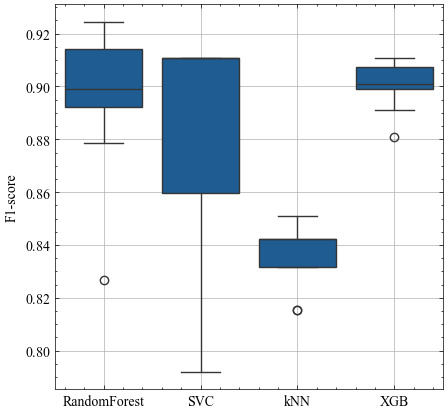

In [ ]:
fig, ax1 = plt.subplots(1,1, figsize=(5,5))
sns.boxplot(data=df_metrics, 
            y='f1_score',
            x='model', 
            # estimator = 'mean',
            # hue='model', 
            ax=ax1)
ax1.set_ylabel('F1-score')
ax1.set_xlabel('')
ax1.grid()
# fig.savefig('./plots/F1-scores.png', dpi=300)

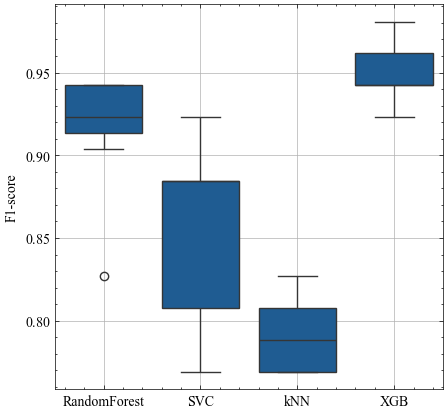

In [ ]:
fig, ax1 = plt.subplots(1,1, figsize=(5,5))
sns.boxplot(data=df_metrics, 
            y='recall',
            x='model', 
            # estimator = 'mean',
            # hue='model', 
            ax=ax1)
ax1.set_ylabel('F1-score')
ax1.set_xlabel('')
ax1.grid()
# fig.savefig('./plots/F1-scores.png', dpi=300)

## 3. Feature importance

In [ ]:
import shap

shap.initjs()


In [ ]:
model = best_models['RandomForest']
explainer = shap.Explainer(model)
shap_values = explainer(X)

In [ ]:
X.shape

(656, 54)

/Users/mikhailgasanov/geo/lib/python3.12/site-packages/matplotlib/ticker.py:2918: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)


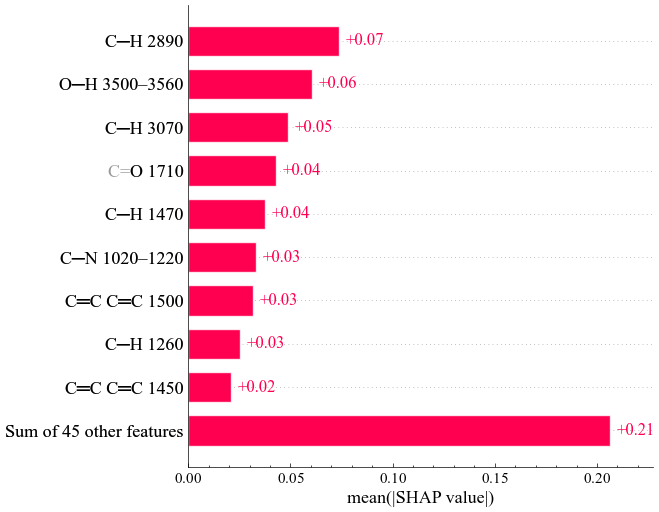

In [ ]:
fig, ax1 = plt.subplots(1,1, figsize=(6,6))
ax1 = shap.plots.bar(shap_values[:, :, 1], ax=ax1, show_data=False)
fig.savefig('./plots/SHAP.png', dpi=300)

In [ ]:
df_s

NameError: name 'df' is not defined